In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## Construction related data collected from the Australian Bureau of Statistics
CONSTRUCTION_INPUTS = "../data/Input Prices for Constructions.xlsx"
CONSTRUCTION_OUTPUTS = "../data/Output Prices from Constructions.xlsx"
CONSTRUCTION_WORKS = "../data/Value of Construction Works.xlsx"

## Key variables for illiquid stock analysis
FRED = "FEDFUNDS"
ILLIQUID_TICKER = "KELYB"
LIQUID_INDEX_TICKER = "SPY"

In [3]:
## CODE from M1 Lesson 1 of FD

def get_fred_data(param_list, start_date, end_date) -> pd.DataFrame:
    df = pdr.DataReader(param_list, "fred", start_date, end_date) 
    return df.reset_index()

In [4]:
c_inputs = pd.read_excel(CONSTRUCTION_INPUTS, sheet_name='Data1')
c_outputs = pd.read_excel(CONSTRUCTION_OUTPUTS, sheet_name='Data1')
c_works = pd.read_excel(CONSTRUCTION_WORKS, sheet_name='Data1')

## Data Analysis for Construction Loan

### Key Features from each data set
1. Weighted Average Index Numbers for each type of material across Australia: This is used as proxy for material prices
2. Building Construction Outputs Index Numbers: This is used as proxy for Contractor and Labour Costs
3. Value of Construction Works: This is used as proxy for productivity

In [5]:
inputs_col = {
    'Unnamed: 0': 'Date',
    'Index Number ;  All groups ;  Weighted Average of 6 Capital Cities ;': 'Construction Materials Index'
}
outputs_col = {
    'Unnamed: 0': 'Date',
    'Index Number ;  30 Building construction Australia ;': 'Building Construction Output Index',
    'Index Number ;  3011 House construction Australia ;': 'House Construction Output Index',
    'Index Number ;  3019 Other residential building construction Australia ;': 'Other Residential Output Index',
    'Index Number ;  3020 Non-residential building construction Australia ;': 'Non-Residential Output Index',
}
works_col = {
    'Unnamed: 0': 'Date',
    'Value of work commenced ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;': 'Value of Work Commenced ($)',
    'Value of work completed ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;': 'Value of Work Completed ($)',
    'Value of work done during quarter ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;': 'Value of Work Done ($)'
}

In [6]:
def clean_construction(input_df: pd.DataFrame, output_df: pd.DataFrame, work_df: pd.DataFrame, inputs_col: dict, outputs_col: dict, works_col: dict):

    def extract_and_rename(df: pd.DataFrame, cols_mapper: dict):

        df = df[cols_mapper.keys()]
        df = df.rename(columns=cols_mapper)
        df = df.drop([i for i in range(0, 9)]).dropna()

        return df
    
    input_df = extract_and_rename(input_df, inputs_col)
    output_df = extract_and_rename(output_df, outputs_col)
    work_df = extract_and_rename(work_df, works_col)

    final_df = pd.merge(pd.merge(input_df, output_df, how='outer', on='Date'), work_df, how='outer', on='Date').dropna().reset_index(drop=True)
    final_df['Date'] = final_df['Date'].apply(pd.to_datetime)

    return final_df

In [7]:
constuction_df = clean_construction(c_inputs, c_outputs, c_works, inputs_col, outputs_col, works_col)
constuction_df.head()

,Date,Construction Materials Index,Building Construction Output Index,House Construction Output Index,Other Residential Output Index,Non-Residential Output Index,Value of Work Commenced ($),Value of Work Completed ($),Value of Work Done ($)
0,1996-09-01,68.3,58.5,59.3,60.1,57.5,6515395,6211390,6983475
1,1996-12-01,68.4,58.7,59.2,60.3,57.8,7250841,7296987,7330211
2,1997-03-01,68.6,59.2,59.3,61,58.6,7005280,6212857,6814154
3,1997-06-01,69.1,59.4,59.3,61.4,59.1,7360961,6729118,7246332
4,1997-09-01,69.3,60,59.6,62.1,59.8,8198014,7652598,7795915


In [8]:
aus_rates = pd.read_html('https://www.rba.gov.au/statistics/cash-rate/')[0]
aus_rates = aus_rates.drop(columns=['Related Documents'])
aus_rates = aus_rates.drop([372 + i for i in range(12)])
aus_rates['Effective Date'] = aus_rates['Effective Date'].apply(pd.to_datetime)
aus_rates = aus_rates.sort_values(by='Effective Date')[['Effective Date', 'Cash rate target %']]
aus_rates['Cash rate target %'] = aus_rates['Cash rate target %'].apply(lambda x: np.float64(x))
aus_rates.head()

,Effective Date,Cash rate target %
371,1990-09-05,14.0
370,1990-10-15,13.0
369,1990-11-07,13.0
368,1990-12-18,12.0
367,1991-02-06,12.0


In [9]:
final_construction_df = pd.merge_asof(constuction_df, aus_rates, left_on='Date', right_on='Effective Date', direction='backward').drop(columns=['Effective Date'])
final_construction_df.head()

,Date,Construction Materials Index,Building Construction Output Index,House Construction Output Index,Other Residential Output Index,Non-Residential Output Index,Value of Work Commenced ($),Value of Work Completed ($),Value of Work Done ($),Cash rate target %
0,1996-09-01,68.3,58.5,59.3,60.1,57.5,6515395,6211390,6983475,7.0
1,1996-12-01,68.4,58.7,59.2,60.3,57.8,7250841,7296987,7330211,6.5
2,1997-03-01,68.6,59.2,59.3,61,58.6,7005280,6212857,6814154,6.0
3,1997-06-01,69.1,59.4,59.3,61.4,59.1,7360961,6729118,7246332,5.5
4,1997-09-01,69.3,60,59.6,62.1,59.8,8198014,7652598,7795915,5.0


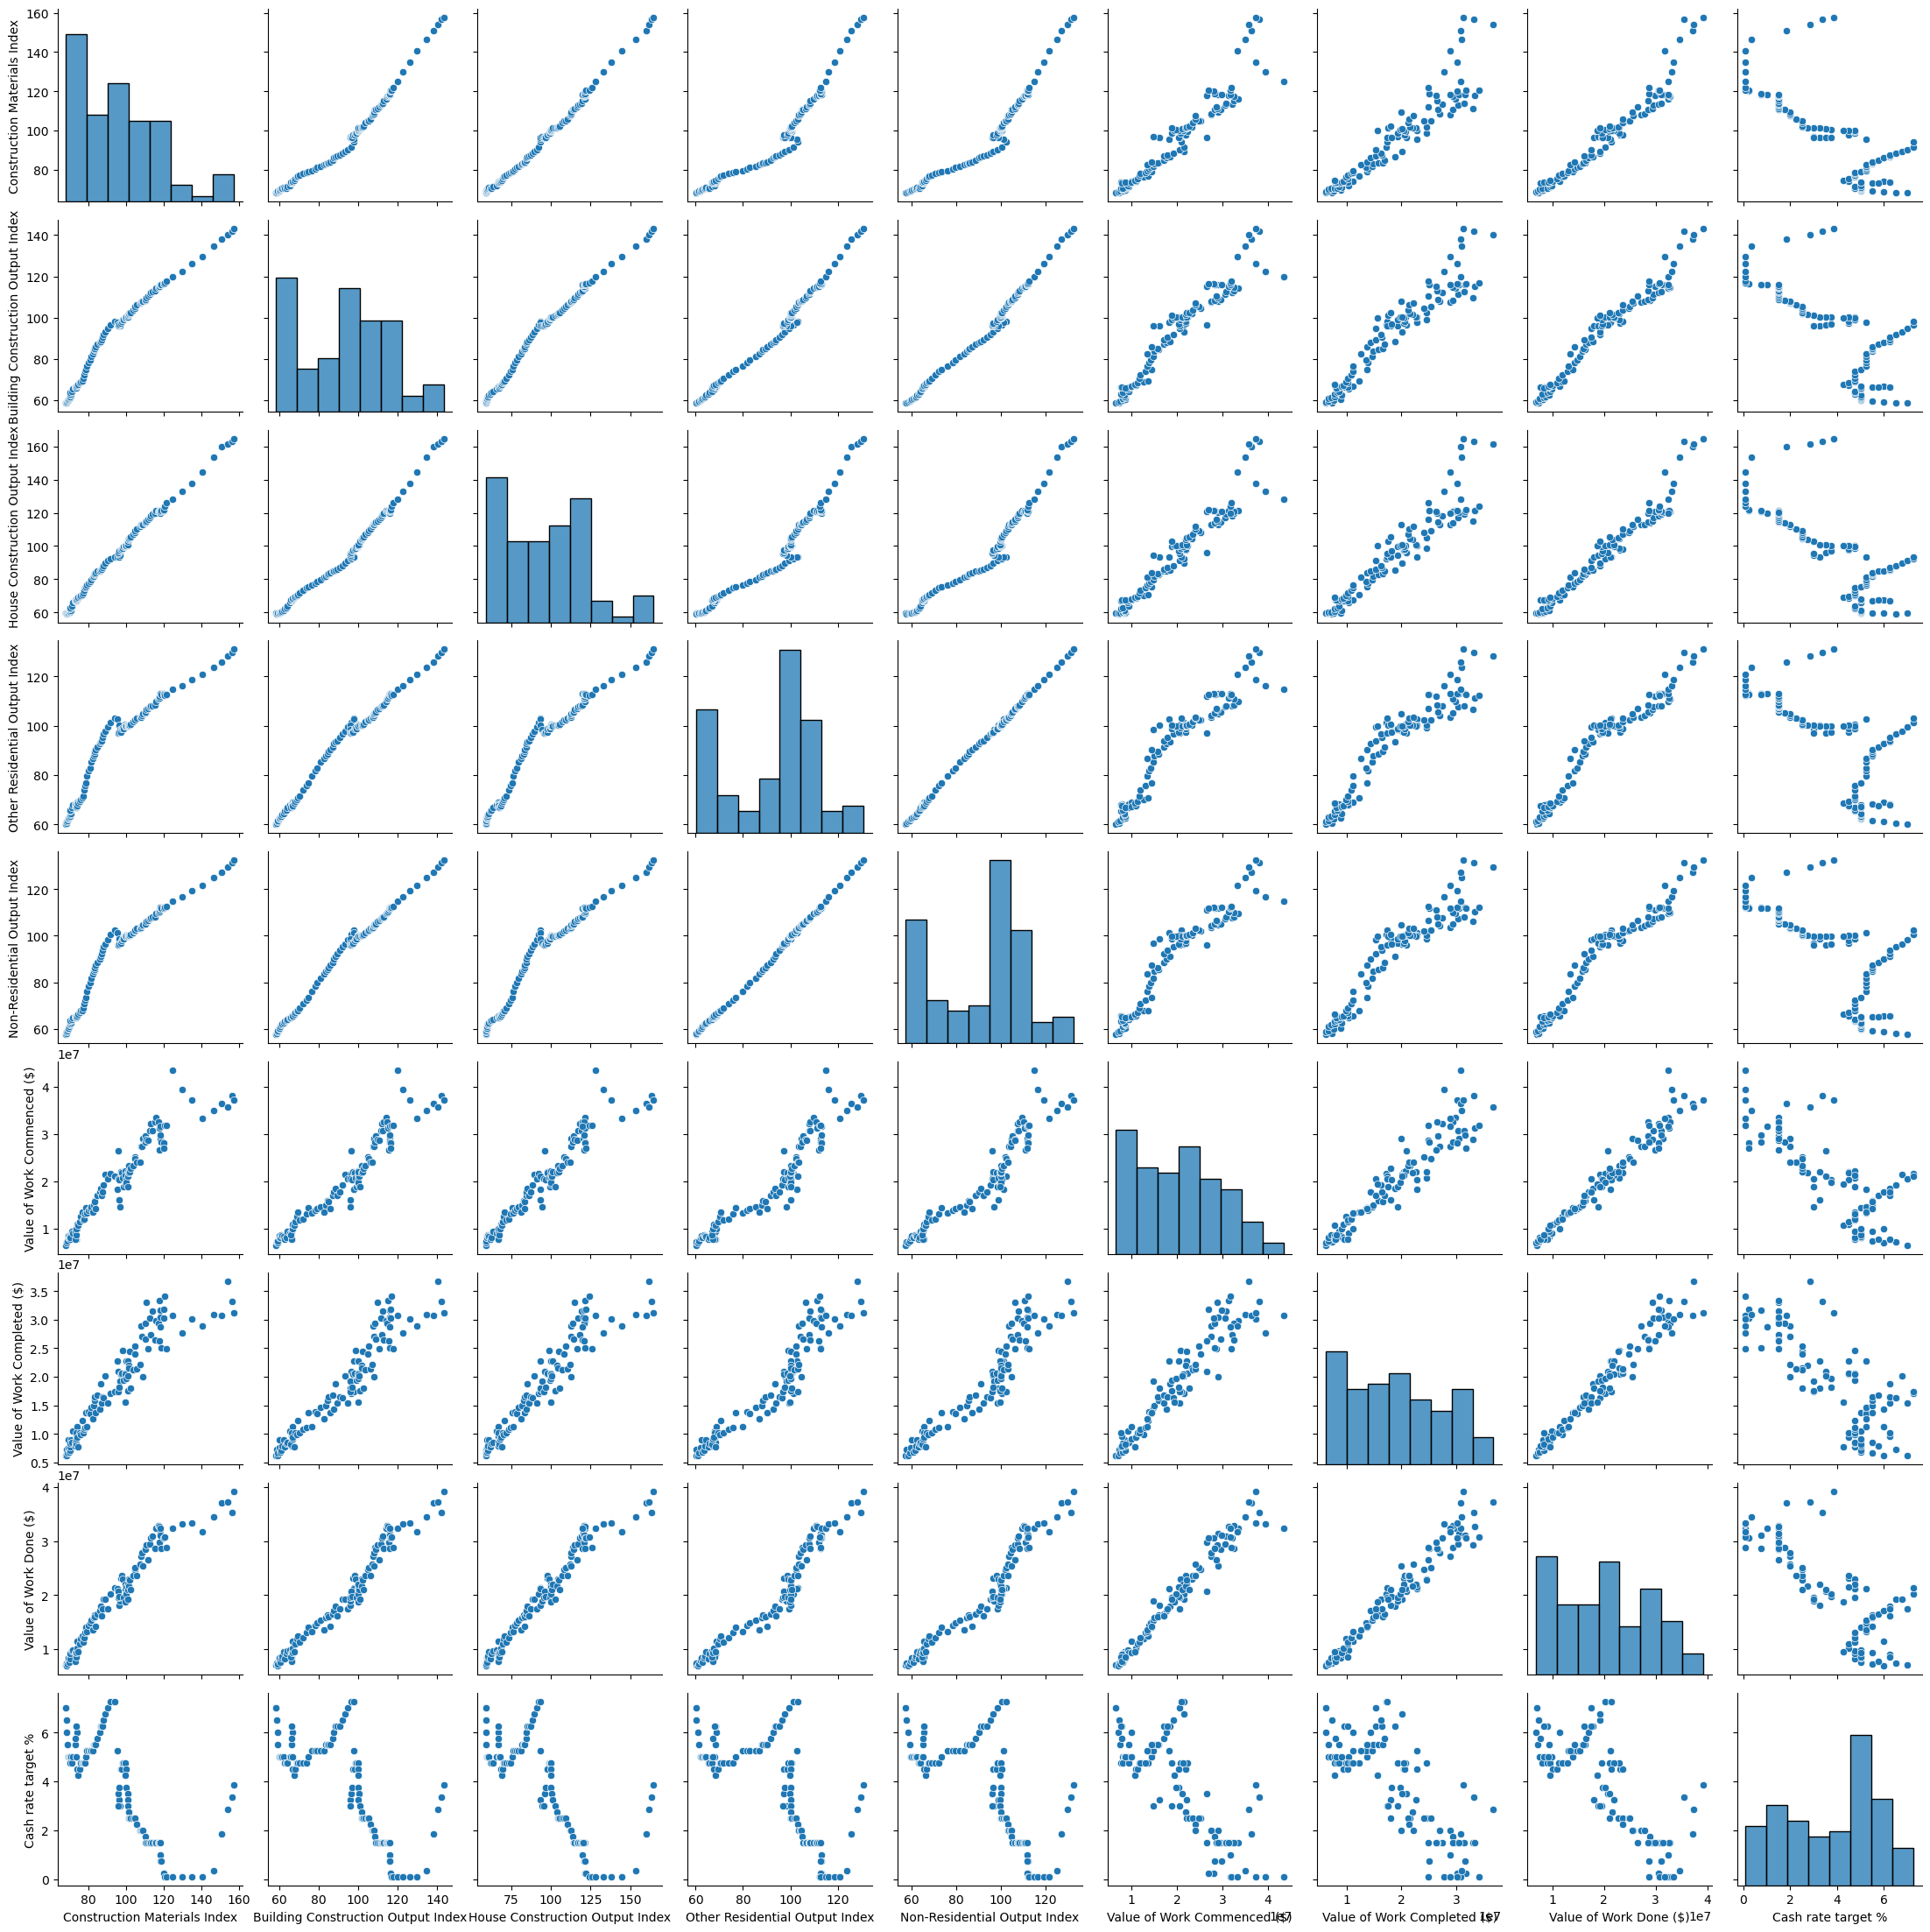

In [10]:
g = sns.PairGrid(data=final_construction_df.drop(columns=['Date']))
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

From the pair plot above, we can see a positive relationship between the input and output indices. This indicates that when prices of goods are more expensive, the labour and output costs of construction tend to be higher as expected. An interesting find is the relationship between the productivity proxies (value of work done and completed), and the materials and outputs indices. The positive relationship is evident and will need further investigation as we are unsure whether the calculation of work done is impacted by inflation and increasing costs of goods.

For the cash rate, we can see a negative relationship between the rates and the remaining columns. The interesting find would be the value of work against the cash rate. This is a good measurement for loans as we see that the productivity might drop during higher levels of cash rate as costs of products might be higher and impacts the timeliness of the project.

## Data Extraction and Analysis for Illquid Stock

In [11]:
PERIOD_START = "2017-01-01"
PERIOD_END = "2024-01-01"

In [12]:
def extract_and_process_stocks() -> pd.DataFrame:

    stock = yf.Ticker(ILLIQUID_TICKER)
    stock_df = stock.history(start=PERIOD_START, end=PERIOD_END).reset_index()
    stock_df['Date'] = stock_df['Date'].dt.tz_localize(None)

    index = yf.Ticker(LIQUID_INDEX_TICKER)
    index_df = index.history(start=PERIOD_START, end=PERIOD_END).reset_index()
    index_df['Date'] = index_df['Date'].dt.tz_localize(None)
    index_df.head()

    fed_rate = get_fred_data(param_list=[FRED], start_date=PERIOD_START, end_date=PERIOD_END)
    fed_rate_df = pd.DataFrame(columns=['Date'])
    fed_rate_df['Date'] = pd.date_range(PERIOD_START, PERIOD_END, freq='D')
    fed_rate_df = pd.merge(fed_rate_df, fed_rate, how='left', left_on='Date', right_on='DATE').drop(columns=['DATE']).ffill()
    fed_rate_df['FEDFUNDS'] = fed_rate_df['FEDFUNDS'].apply(np.floor)

    return pd.merge(pd.merge(stock_df, index_df, how='inner', on='Date', suffixes=[f"_{ILLIQUID_TICKER}", f"_{LIQUID_INDEX_TICKER}"]), fed_rate_df, on="Date")

In [13]:
final_df = extract_and_process_stocks()
final_df.tail(10)

,Date,Open_KELYB,High_KELYB,Low_KELYB,Close_KELYB,Volume_KELYB,Dividends_KELYB,Stock Splits_KELYB,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Dividends_SPY,Stock Splits_SPY,Capital Gains,FEDFUNDS
1750,2023-12-15,20.90,20.90,20.90,20.90,100,0.0,0.0,469.489990,470.700012,467.429993,469.329987,141319300,1.906,0.0,0.0,5.0
1751,2023-12-18,20.90,20.90,20.90,20.90,0,0.0,0.0,470.980011,472.980011,469.890015,471.970001,70375300,0.000,0.0,0.0,5.0
1752,2023-12-19,20.90,20.90,20.90,20.90,0,0.0,0.0,472.529999,474.920013,472.450012,474.839996,55761800,0.000,0.0,0.0,5.0
1753,2023-12-20,20.90,20.90,20.90,20.90,0,0.0,0.0,473.959991,475.899994,467.820007,468.260010,102921000,0.000,0.0,0.0,5.0
1754,2023-12-21,21.15,21.15,21.15,21.15,100,0.0,0.0,471.329987,472.980011,468.839996,472.700012,86667500,0.000,0.0,0.0,5.0
1755,2023-12-22,21.65,21.65,21.65,21.65,200,0.0,0.0,473.859985,475.380005,471.700012,473.649994,67126600,0.000,0.0,0.0,5.0
1756,2023-12-26,21.65,21.65,21.65,21.65,0,0.0,0.0,474.070007,476.579987,473.989990,475.649994,55387000,0.000,0.0,0.0,5.0
1757,2023-12-27,21.65,21.65,21.65,21.65,0,0.0,0.0,475.440002,476.660004,474.890015,476.510010,68000300,0.000,0.0,0.0,5.0
1758,2023-12-28,21.65,21.65,21.65,21.65,0,0.0,0.0,476.880005,477.549988,476.260010,476.690002,77158100,0.000,0.0,0.0,5.0
1759,2023-12-29,21.65,21.65,21.65,21.65,0,0.0,0.0,476.489990,477.029999,473.299988,475.309998,122234100,0.000,0.0,0.0,5.0


### Analysis of the Volumes

Text(0.5, 0.98, 'Volume Time Series')

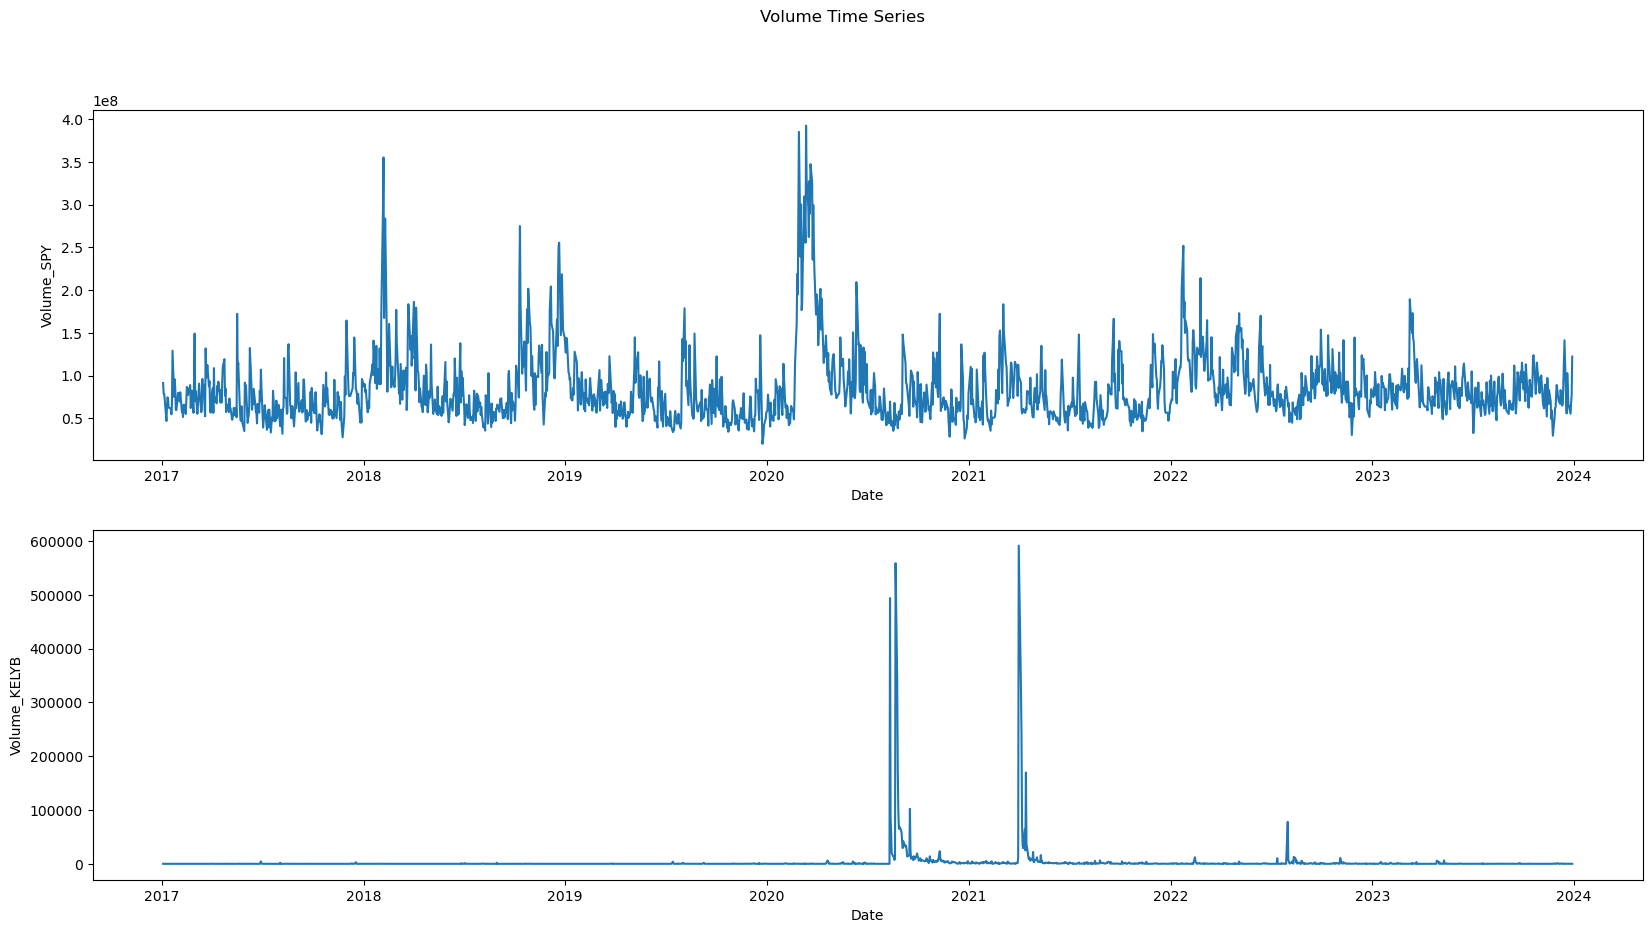

In [14]:
## Showing the illiquidity of KELYB
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x='Date', y=f'Volume_{LIQUID_INDEX_TICKER}', data=final_df, ax=ax[0])
sns.lineplot(x='Date', y=f'Volume_{ILLIQUID_TICKER}', data=final_df, ax=ax[1])
fig.suptitle('Volume Time Series')

We can see that the volume of the KELYB stock is so much smaller than the SPY and also trades very infrequently. This indicates the illiquidity of this stock.

Text(0.5, 0.98, 'Volume Distribution')

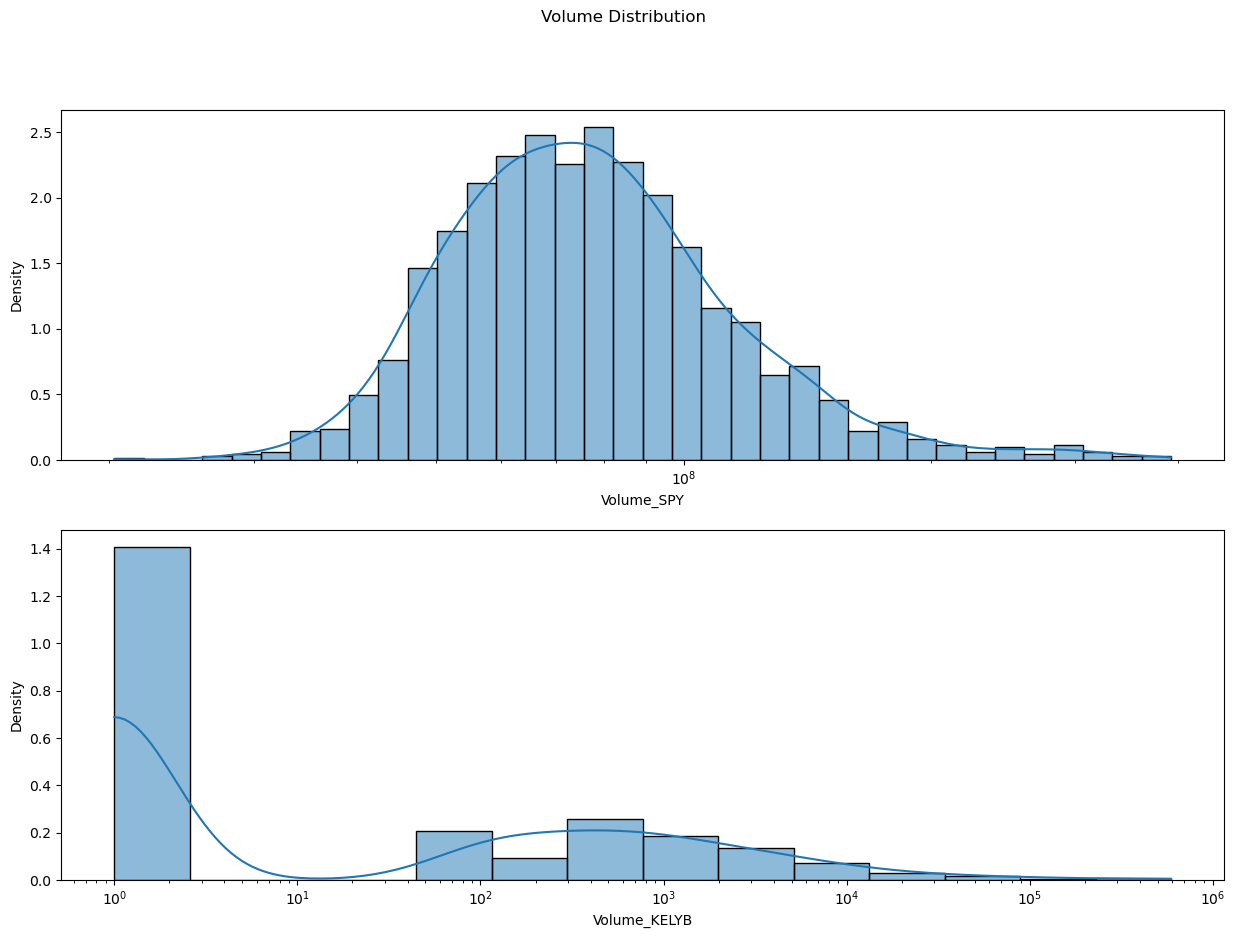

In [15]:
## Showing the illiquidity of KELYB
## Note that plots are in log-scale
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.histplot(data=final_df[f'Volume_{ILLIQUID_TICKER}'] + 1, log_scale=True, kde=True, stat='density', ax=ax[1])
sns.histplot(data=final_df[f'Volume_{LIQUID_INDEX_TICKER}'] + 1, log_scale=True, kde=True, stat='density', ax=ax[0])
fig.suptitle('Volume Distribution')

The distribution of the log-scaled volume shows how liquid the stocks are by examining the amount of trades that occured in a day. KELYB has bi-modal distribution where one is close to 0 and the other at around 1000. This has also confirmed the illiquidity of the KELB stock.

### Analysis on Returns

In [16]:
final_df[f'Log Returns {LIQUID_INDEX_TICKER}'] = np.log10(final_df[f'Close_{LIQUID_INDEX_TICKER}']/final_df[f'Close_{LIQUID_INDEX_TICKER}'].shift(1))
final_df[f'Log Returns {ILLIQUID_TICKER}'] = np.log10(final_df[f'Close_{ILLIQUID_TICKER}']/final_df[f'Close_{ILLIQUID_TICKER}'].shift(1))

Text(0.5, 0.98, 'Log Returns Time Series')

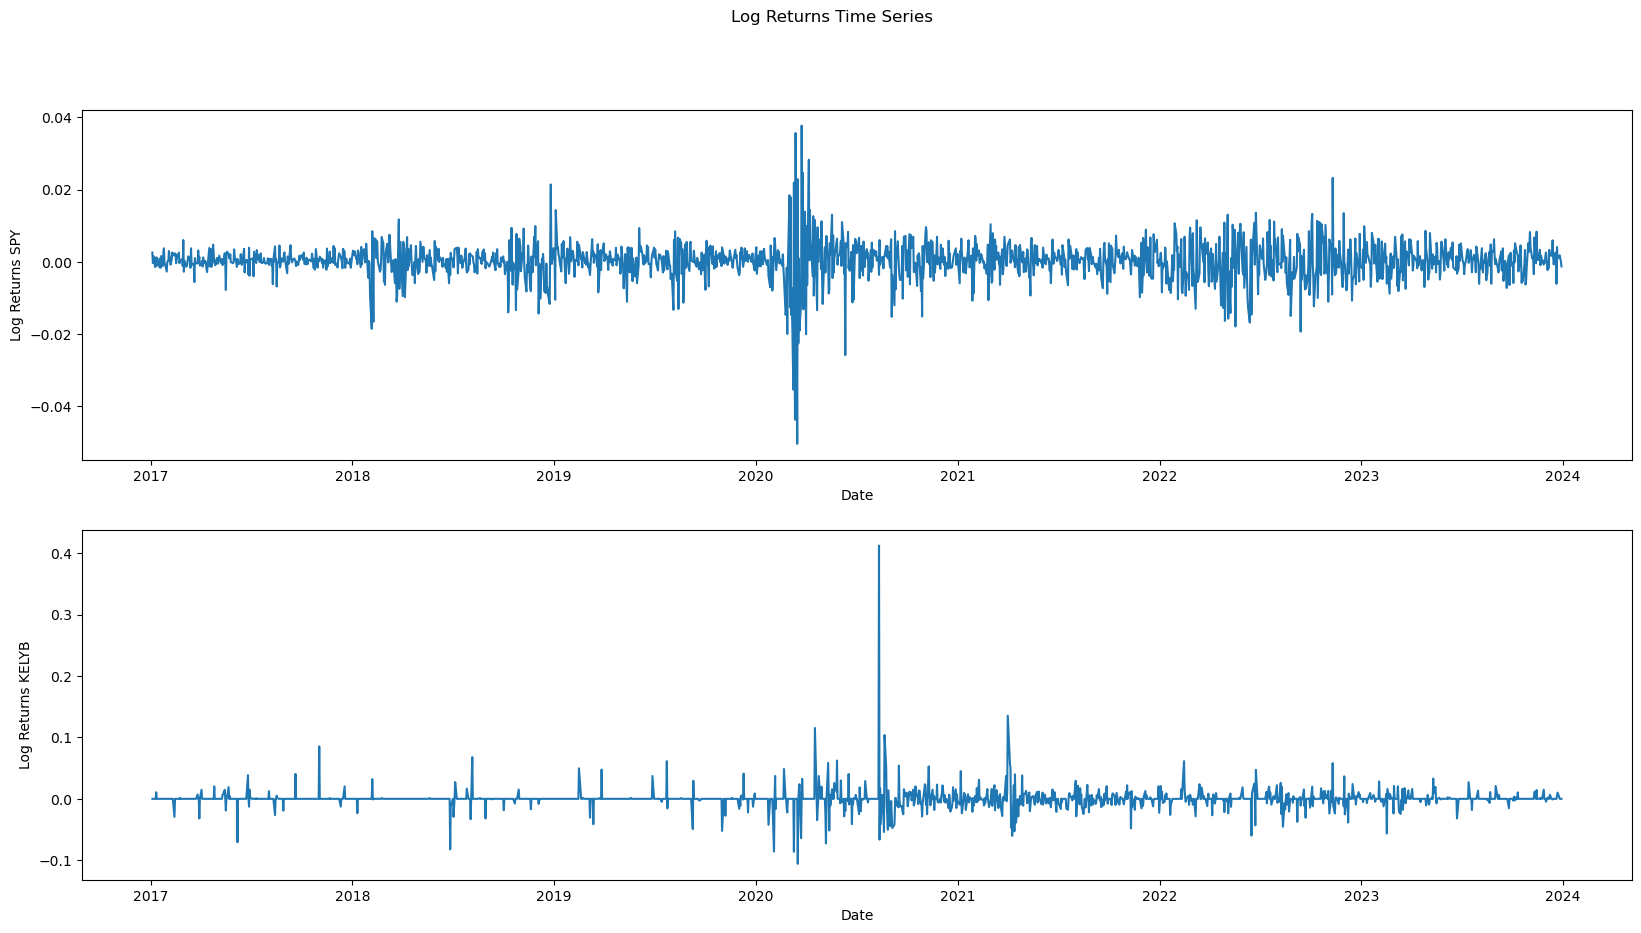

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(x='Date', y=f'Log Returns {LIQUID_INDEX_TICKER}', data=final_df, ax=ax[0])
sns.lineplot(x='Date', y=f'Log Returns {ILLIQUID_TICKER}', data=final_df, ax=ax[1])
fig.suptitle('Log Returns Time Series')

Looking at the time series for the log-returns, we can see that the illiquid stock has a log-returns close to 0 quite often before 2020. Looking at the range of the returns on the y-axis, we can also confirm that the illiquid is very volatile, as compared to the SPY index.

Text(0.5, 0.98, 'Log Returns')

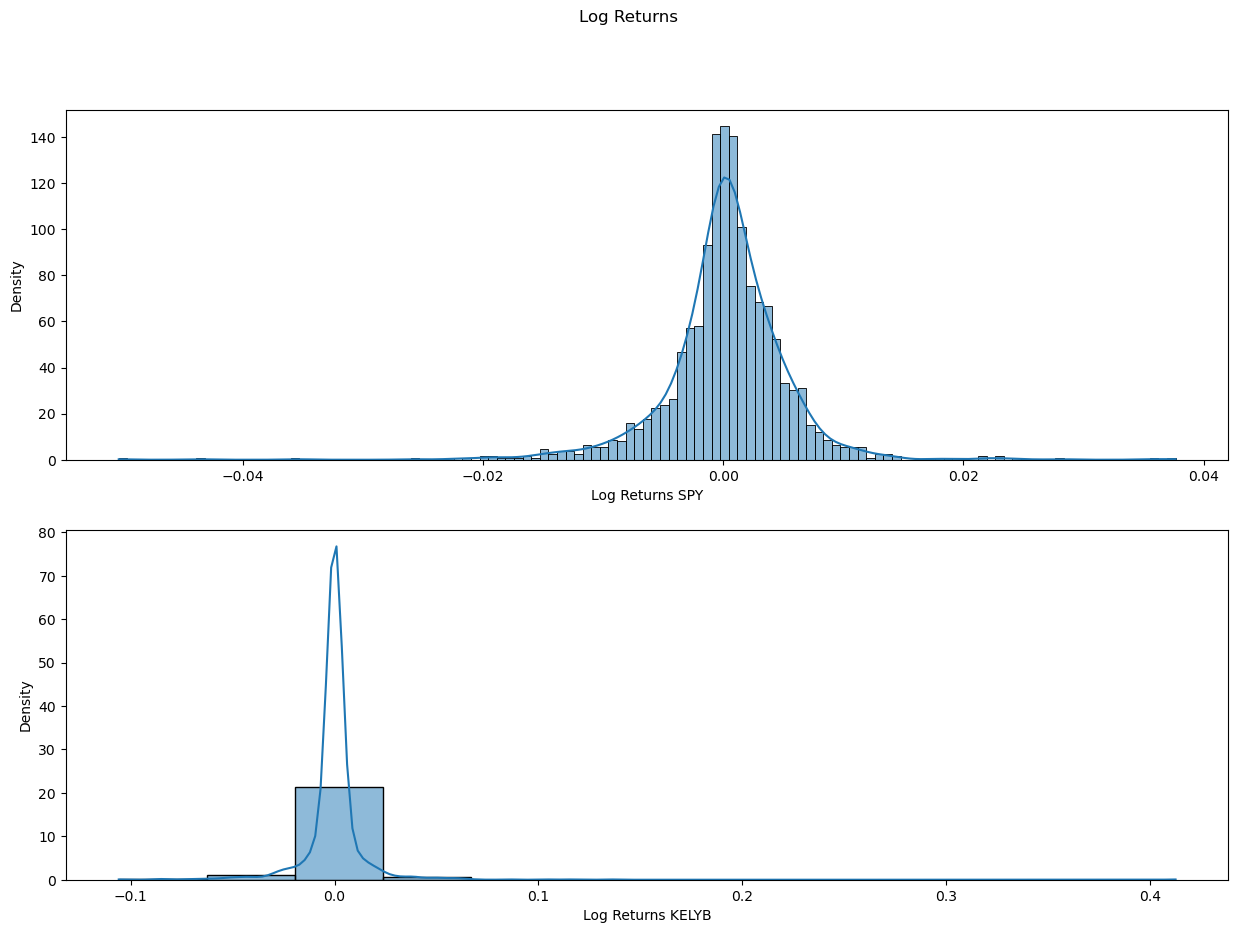

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.histplot(data=final_df[f'Log Returns {ILLIQUID_TICKER}'], kde=True, stat='density', ax=ax[1])
sns.histplot(data=final_df[f'Log Returns {LIQUID_INDEX_TICKER}'], kde=True, stat='density', ax=ax[0])
fig.suptitle('Log Returns')

Here, we examine the distributions of the log-returns, and find that the SPY fund has a more normal distribution as compared to the KELYB stock. 

/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_83346/1321793629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] = np.log10(vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] + 1)
/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_83346/1321793629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_return[f'Volume_{ILLIQUID_TICKER}'] = np.log10(vol_return[f'Volume_{ILLIQUID_TICKER}'] + 1)


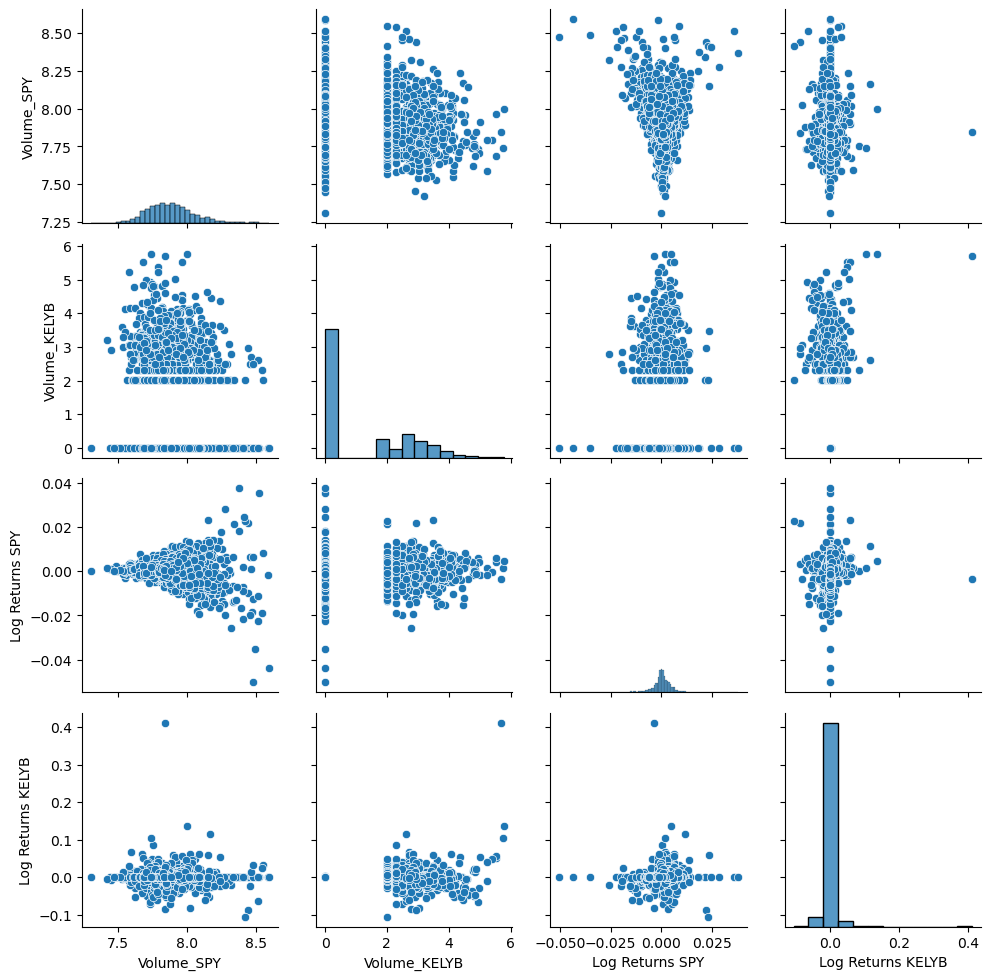

In [19]:
vol_return = final_df[[f'Volume_{LIQUID_INDEX_TICKER}', f'Volume_{ILLIQUID_TICKER}', f'Log Returns {LIQUID_INDEX_TICKER}', f'Log Returns {ILLIQUID_TICKER}']]
vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] = np.log10(vol_return[f'Volume_{LIQUID_INDEX_TICKER}'] + 1)
vol_return[f'Volume_{ILLIQUID_TICKER}'] = np.log10(vol_return[f'Volume_{ILLIQUID_TICKER}'] + 1)
g = sns.PairGrid(data=vol_return)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

Looking at the pair plot, we cannot spot much correlation between the volume and the log-returns of the stocks. The only notable relationship is between the returns and volume of the SPY ETF. 

/var/folders/p0/pbqvxybs0lg7lb7xzx1n1m440000gn/T/ipykernel_83346/2400717402.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] = np.log10(illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] + 1)


<Figure size 2000x2000 with 0 Axes>

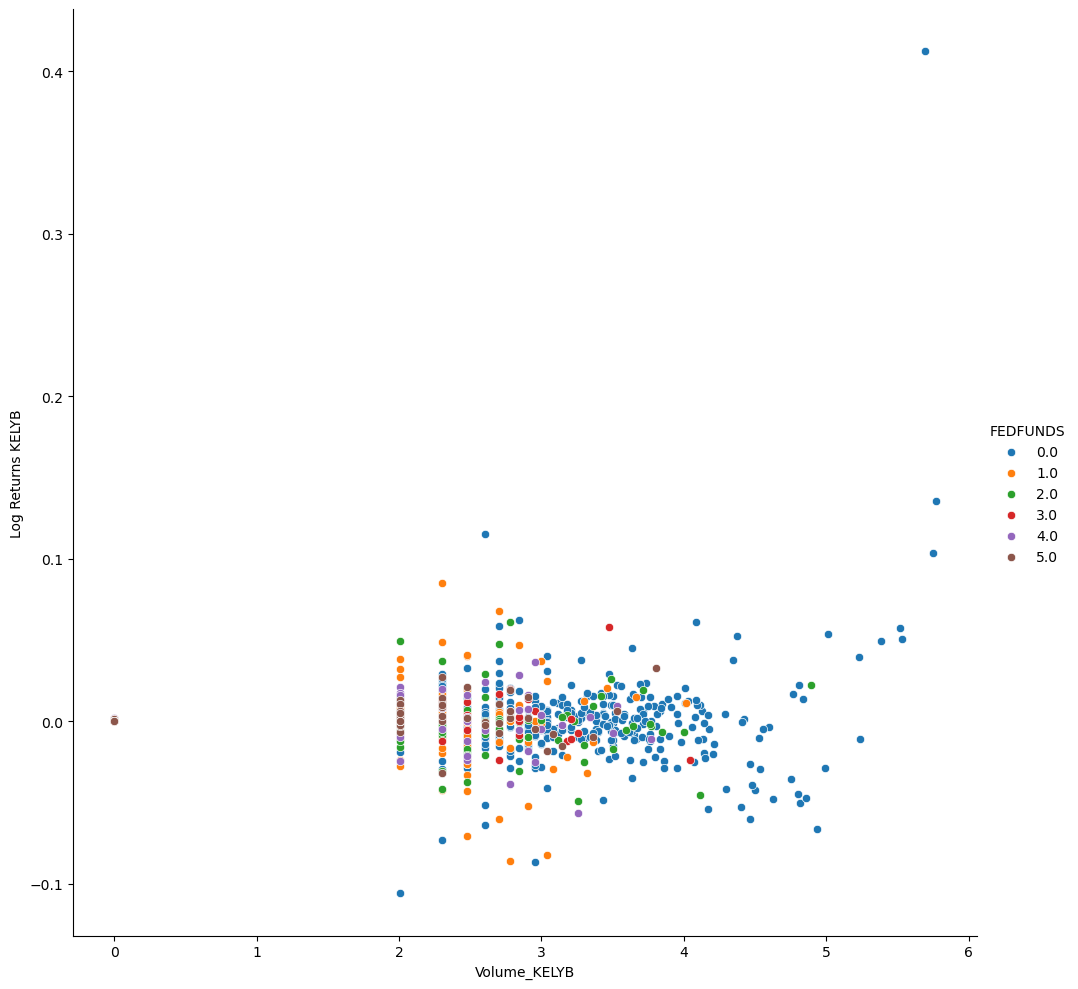

In [20]:
illiquid_vol = final_df[[f'Volume_{ILLIQUID_TICKER}', 'FEDFUNDS', f'Log Returns {ILLIQUID_TICKER}']]
illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] = np.log10(illiquid_vol[f'Volume_{ILLIQUID_TICKER}'] + 1)
plt.figure(figsize=(20, 20))
g = sns.FacetGrid(data=illiquid_vol, hue='FEDFUNDS', height=10, aspect=1)
g.map(sns.scatterplot, f'Volume_{ILLIQUID_TICKER}', f'Log Returns {ILLIQUID_TICKER}')
g.add_legend()

From this plot, we see are able to observe that the volume and log-returns for KELYB has larger variances and spread when the Interest rates are in the range of 0-1% (Indexed as FEDFUNDS=0.0). Moreover, when the interest rates are large (i.e. FEDFUNDS=5.0, which means between range 5-6%), we see that there are times where trading volume is at 0. This indicates that the interest rates affect the liquidity and returns of KELYB.